In [2]:
from sklearn.cluster import KMeans
from PIL import Image
import sys
import os
import math
import numpy as np
from numba import njit

from PIL import Image, ImageDraw, ImageFont

In [3]:
testlist = np.array([1,2,3,10,15, 20])
testlist = testlist.reshape(2,3)
# print(testlist)

import numpy as np
a = np.array([1, 3, 5, 6, 9, 10, 14, 15, 56])
a = a.reshape(3,3)
print(a)

np.where(np.logical_and(a>=6, a<=10))
# im

[[ 1  3  5]
 [ 6  9 10]
 [14 15 56]]


(array([1, 1, 1], dtype=int64), array([0, 1, 2], dtype=int64))

In [4]:
blue = [ range(0,20), range(0,20), range(200,255)]
# blue = [0,0,255]
blue = np.array(blue,dtype = object)
im = Image.open('./target/empty_bilboard1_annotated.jpg').convert('RGB')
im = np.array(im)

x,y = np.where(np.all(im == blue, axis= 2))
x,y = np.where(np.logical_and(im[2] >= 200, im[2] <= 255))
x,y = np.where(np.all(np.logical_and(im >= 200, im <= 255), axis= 2))

x,y

(array([  0,   0,   0, ..., 340, 340, 340], dtype=int64),
 array([  0,   1,   2, ..., 509, 510, 511], dtype=int64))

In [5]:
@njit()
def get_four_points_helper(npim, color = 'Blue'):
    # find points where the Red and Green values are below 50 and Blue values are above 200. 
    if color == 'Red': 
        x,y = np.where(np.logical_and(np.logical_and(npim[:,:,0] >200, npim[:,:,1] < 50), npim[:,:,2] < 50))
    if color == 'Green':
        x,y = np.where(np.logical_and(np.logical_and(npim[:,:,0] <50, npim[:,:,1] > 200), npim[:,:,2] < 50))
    if color == 'Blue':
        x,y = np.where(np.logical_and(np.logical_and(npim[:,:,0] <50, npim[:,:,1] < 50), npim[:,:,2] > 200))
    # zip the x,y coordinates into a list of 2-d array.
    zipped = np.column_stack((x,y))
    return zipped
def get_four_points(npim, color = "Blue"):
    '''
    Given a preprocessed image, return four points to apply homography.

    Params: 
        npim (2d np.array): np converted color image of preprocessed image.
        color: the kind of color to search for.
        NOTE: this image is preprocessed with colored annotations through Microsoft Paint.
        NOTE: because the image is saved as a JPG, the color values are compressed, and thus
            we cannot search for exact matches for the blue value.
        NOTE: since the image is extracted using Image.open, 
            the color ordering is RGB. so npim[:,:,0] returns RED values for the given point
            and npim[:,:,1] GREEN, npim[:,:,2] BLUE.
    Returns:
        4 cluster centers found using the KMeans clustering algorithm
 ''' 
    zipped = get_four_points_helper(npim,color)
    # # find points where the Red and Green values are below 50 and Blue values are above 200. 
    # if color == 'Red': 
    #     x,y = np.where(np.logical_and(np.logical_and(npim[:,:,0] >200, npim[:,:,1] < 50), npim[:,:,2] < 50))
    # if color == 'Green':
    #     x,y = np.where(np.logical_and(np.logical_and(npim[:,:,0] <50, npim[:,:,1] > 200), npim[:,:,2] < 50))
    # if color == 'Blue':
    #     x,y = np.where(np.logical_and(np.logical_and(npim[:,:,0] <50, npim[:,:,1] < 50), npim[:,:,2] > 200))
    # # zip the x,y coordinates into a list of 2-d array.
    # zipped = np.column_stack((x,y))

    # fit a KMeans clustering algorithm to find the 4 converging points. 
    # NOTE: this breaks the njit compiler. If we are to optimize for speed, we could possibly
    # separate the program from the pure nparray and the KMeans algorithm. 
    
    means = KMeans(4).fit(zipped)

    # return just the 4 cluster centers found from the KMeans clustering algorithm.
    return means.cluster_centers_

In [8]:
bil1 = Image.open('./target/empty_bilboard1_annotated.jpg').convert('RGB')
bil1 = np.array(bil1)
a = get_four_points(bil1)
# a.sort(axis=0)
# first val of coordinate = longitude (downward)
# second val of coordinate = latitude (eastward)
# a[:,0],a
# np.where(a == a.max()), a
a.sum(axis=1)
a[a.sum(axis=1).argmin()],a 
def order_points_josep(arr):
    origin = arr[arr.sum(axis=1).argmin()] 

    lowest_x1 = arr[arr[:,1].argmin()]
    # a[arr[:,1].argmin()],a
    if np.array_equal(lowest_x1, origin):
        x1_index = np.where(arr[:,1] == np.partition(arr[:,1],1)[1])[0][0]
        lowest_x1 = a[x1_index]
    lowest_x0 = arr[arr[:,0].argmin()]
    if np.array_equal(lowest_x0, origin):
        x0_index = np.where(arr[:,0] == np.partition(arr[:,0],1)[1])[0][0]
        # lowest_x0 = np.partition(a[:,0],1)[1]
        lowest_x0 = a[x0_index]
        # lowest_x0 = x0_index

    # a[a[:,1].argmin()]
    farthest  = arr[arr.sum(axis=1).argmax()] 

    # np.partition(a[:,1],1)[1], a
    return np.array([origin,lowest_x0,lowest_x1,farthest])
order_points_josep(a)
# np.linalg.eig(a)
# a
# a.max()
# def order_np(arr):
# np.where(a.sum(axis=1) )


array([[ 23.26666667, 192.03333333],
       [ 64.07407407, 322.59259259],
       [150.86111111, 188.47222222],
       [173.39285714, 326.39285714]])

In [223]:
# https://www.pyimagesearch.com/2016/03/21/ordering-coordinates-clockwise-with-python-and-opencv/ 
# the main difference is that because of the ordering of the points for image manipulation, order_points returns a list of counterclockwise points. 
from scipy.spatial import distance as dist
import numpy as np
# gets the counterclockwise ordering of the given four points.
def order_points(pts):
	xSorted = pts[np.argsort(pts[:, 0]), :]
	leftMost = xSorted[:2,:]
	rightMost = xSorted[2:, :]
	leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
	(tl, bl) = leftMost
	D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
	(br, tr) = rightMost[np.argsort(D)[::-1], :]
	return np.array([tl, tr, br, bl], dtype="float32")
order_points(a)

array([[ 23.266666, 192.03334 ],
       [150.86111 , 188.47223 ],
       [173.39285 , 326.39285 ],
       [ 64.07407 , 322.5926  ]], dtype=float32)

In [217]:
bil2 = Image.open('./target/empty_bilboard2_annotated.jpg').convert('RGB')
bil2 = np.array(bil2)
b = get_four_points(bil2)
order_points(b)

array([[123.13333 , 351.66666 ],
       [233.1077  , 380.1846  ],
       [206.06818 , 484.8409  ],
       [ 92.861115, 427.30554 ]], dtype=float32)

In [13]:
# there are blue objects in this image. So we must use Kmeans for green annotated.
bil3 = Image.open('./target/empty_bilboard3_green.jpg').convert('RGB')
bil3 = np.array(bil3)
get_four_points(bil3,'Green')

array([[351.14285714, 376.5       ],
       [185.03703704, 370.22222222],
       [345.36538462, 263.21153846],
       [170.19230769, 266.07692308]])

In [14]:
bil4 = Image.open('./target/empty_bilboard4_annotated.jpg').convert('RGB')
bil4 = np.array(bil4)
get_four_points(bil4)

array([[112.58333333, 277.79166667],
       [297.81111111,  33.34444444],
       [138.11428571,  72.4       ],
       [288.46428571, 272.07142857]])

In [24]:
a= np.array([[1, 2], [3, 5]])
b= np.zeros((2))
x = np.linalg.solve(a,b)
x

array([0., 0.])

255
12
[ 12   0 208]
[ 10   6 204]
[  2   8 214]
[  0   4 236]
[  0   6 214]
[  0   4 240]
[  9   5 226]
[  4   0 241]
[  3   4 244]
[  2   4 247]
[  4   3 218]
[  4   9 214]
22.0 192.0
[ 12   0 208]
174.0 325.5
[  2   4 247]
149.5 189.5
[  0   4 240]
65.0 322.0
[ 10   6 204]


(341, 512, 3)

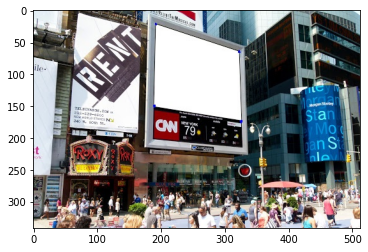

In [349]:

im = Image.open('./target/empty_bilboard1_annotated.jpg').convert('RGB')
# im = Image.open('test.jpg').convert('RGB')


# npim = np.array(im)
# reds=  npim[:,:,0]
# greens = npim[:,:,1]
# blues = npim[:,:,2]
# print(np.max(blues))
# reds
# npim.shape, reds.shape
# npim
x,y = np.where(np.logical_and(np.logical_and(npim[:,:,0] <50, npim[:,:,2] > 200), npim[:,:,1] < 50))
# x,y = np.where(npim[:,:,0] <1 & npim[:,:,1] < 10 & npim[:,:,2] > 200)
zipped = np.column_stack((x,y))
zipped
print(len(zipped))
for x,y in zipped:
    print(npim[x][y])
plt.imshow(npim)
means = KMeans(4).fit(zipped)
means.cluster_centers_
meanclusters = np.array(means.cluster_centers_)
# meanclusters.shape, zipped.shape

for x,y in meanclusters:
    print(x,y)
    print(npim[int(np.round(x))][int(np.round(y))])
npim.shape

(12, 11)


(array([ 9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11],
       dtype=int64),
 array([ 0,  1,  2,  3,  0,  1,  2,  3,  9, 10,  0,  1,  2,  3,  9, 10],
       dtype=int64))

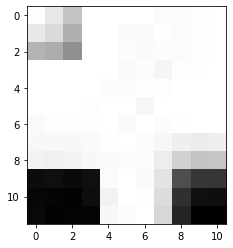

In [250]:
im = Image.open('./target/empty_bilboard1_annotated.jpg').convert('RGB')
im = Image.open('test.jpg').convert('RGB')

npim = np.array(im)
npim = npim[:,:,0]

# npim[21][192]
print(npim.shape)
result = np.where(npim <= 20)
# x,y = np.where(np.all(npim >= 200, axis = 2))
# result[0][0], result[1][0]
npim.shape
import matplotlib.pyplot as plt 

plt.imshow(npim)
npim[10][0]
result
# npim
# npim.shape
# kmeans = KMeans(4).fit(npim)
# kmeans.cluster_centers_.shape
# kmeans.cluster_centers_[1]
# kmeans.labels_

In [100]:
# import cv2 
# im = cv2.imread('test.jpg')
im = Image.open('test.jpg')

npim = np.array(im)
# for pix in npim:
    # print(pix
npim[0]
for row in range(0,len(npim) - 1):
    for col in range(0, len(npim[row])-1):
        # print(npim[row][col])
        # print(col)
        break
        if np.array_equal(col, np.array([0,0,255])):
            print('yes')
            print(npim[row][col])
        # pass
# np.array_equal(npim[1][2], np.array([0,0,255]))
# len(npim),len(npim[340][100])
# npim

In [102]:
#!/usr/bin/python3
# 2018.07.08 10:39:15 CST
# 2018.07.08 11:09:44 CST
import cv2
import numpy as np
## Read and merge
img = cv2.imread("test.jpg")
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

## Gen lower mask (0-5) and upper mask (175-180) of RED
mask1 = cv2.inRange(img_hsv, (0,50,20), (5,255,255))
mask2 = cv2.inRange(img_hsv, (175,50,20), (180,255,255))

## Merge the mask and crop the red regions
mask = cv2.bitwise_or(mask1, mask2 )
croped = cv2.bitwise_and(img, img, mask=mask)

## Display
cv2.imshow("mask", mask)
cv2.imshow("croped", croped)
cv2.waitKey()

-1